# Importing Libraries

In [10]:
import torch

import os
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2

import shutil
import random

import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, ConcatDataset

import torchvision.models as models
import timm 

import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR

# Dataset

In [3]:
train_dataset_path = 'Dataset/Train'
test_dataset_path = 'Dataset/Test'
train_augmented_dataset_path = 'Dataset/Augmented'

In [23]:
train_labels = os.listdir(train_dataset_path)
train_image_count = {label: len(os.listdir(os.path.join(train_dataset_path, label))) for label in train_labels}

In [24]:
print("Number of images in each train label folder:")
for label, count in train_image_count.items():
    print(f"{label}: {count}")

Number of images in each train label folder:
BacterialBlight: 1584
BacterialLeafBlight: 1115
BacterialLeafStreak: 380
Blast: 1738
BrownSpot: 965
Normal: 2232
SheathBlight: 632


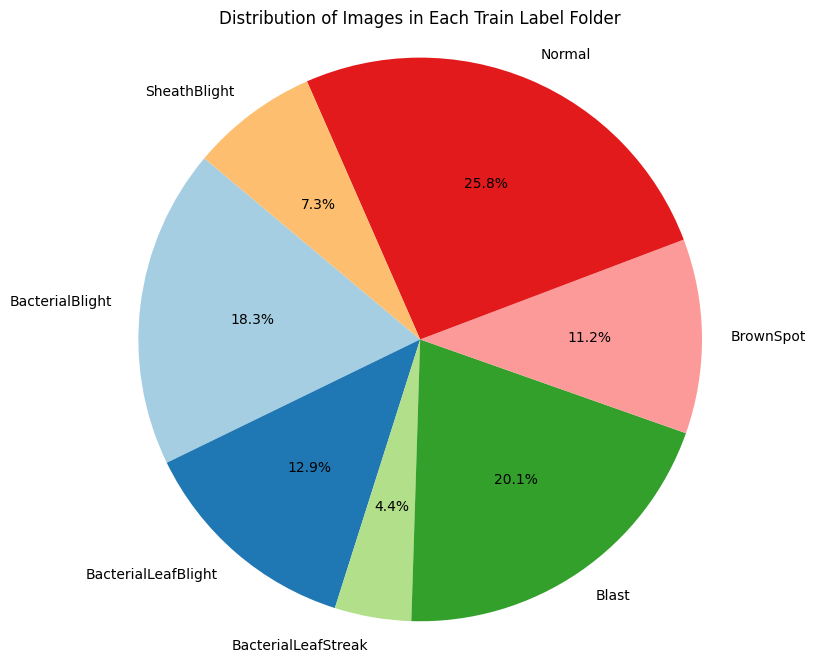

In [25]:
plt.figure(figsize=(8, 8))
plt.pie(train_image_count.values(), labels=train_image_count.keys(), autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Distribution of Images in Each Train Label Folder')
plt.axis('equal')
plt.show()

# Data Augmentation

In [26]:
# Define the transformations for data augmentation
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize image
    transforms.RandomAffine(degrees=40, translate=(0.2, 0.2), scale=(0.8, 1.2)),  # Random affine transformation
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),  # Apply Gaussian blur
    transforms.RandomCrop((224, 224)),  # Randomly crop to 224x224
    transforms.ToTensor(),  # Convert to tensor
])

# Function to preprocess and augment images
def augment_image(image_path, save_path):
    img = Image.open(image_path).convert('RGB')  # Load image and convert to RGB
    augmented_image = data_transforms(img)  # Apply transformations
    augmented_image = augmented_image.numpy()  # Convert to numpy array
    augmented_image = (augmented_image * 255).astype(np.uint8)  # Convert to uint8

    # Save the augmented image
    cv2.imwrite(save_path, cv2.cvtColor(augmented_image.transpose(1, 2, 0), cv2.COLOR_RGB2BGR))

# Paths
train_dataset_path = 'Dataset/Train'
augmented_save_path = 'Dataset/Augmented'

if not os.path.exists(augmented_save_path):
    os.makedirs(augmented_save_path)

# Target number of images for each class
target_image_count = 1500

# Loop through each label folder and process images
for label in os.listdir(train_dataset_path):
    label_path = os.path.join(train_dataset_path, label)
    save_label_path = os.path.join(augmented_save_path, label)

    if not os.path.exists(save_label_path):
        os.makedirs(save_label_path)

    images = os.listdir(label_path)
    current_image_count = len(images)
    print(f"Class: {label} has {current_image_count} images.")

    # If the class has fewer than the target, augment data
    if current_image_count < target_image_count:
        needed_images = target_image_count - current_image_count
        
        # Generate and save augmented images until the target is reached
        while current_image_count < target_image_count:
            for image_file in images:
                image_path = os.path.join(label_path, image_file)
                # Augment the image and save it
                augment_image(image_path, os.path.join(save_label_path, f'aug_{current_image_count}.jpg'))
                
                current_image_count += 1
                if current_image_count >= target_image_count:
                    break

        print(f"Augmentation completed for {label}. New count: {target_image_count}")
    else:
        print(f"Class {label} already has {current_image_count} images.")

Class: BacterialBlight has 1584 images.
Class BacterialBlight already has 1584 images.
Class: BacterialLeafBlight has 1115 images.
Augmentation completed for BacterialLeafBlight. New count: 1500
Class: BacterialLeafStreak has 380 images.
Augmentation completed for BacterialLeafStreak. New count: 1500
Class: Blast has 1738 images.
Class Blast already has 1738 images.
Class: BrownSpot has 965 images.
Augmentation completed for BrownSpot. New count: 1500
Class: Normal has 2232 images.
Class Normal already has 2232 images.
Class: SheathBlight has 632 images.
Augmentation completed for SheathBlight. New count: 1500


In [27]:
# Check the number of images in each augmented folder
augmented_labels = os.listdir(augmented_save_path)
augmented_image_count = {label: len(os.listdir(os.path.join(augmented_save_path, label))) for label in augmented_labels}

print("Number of images in each augmented label folder:")
for label, count in augmented_image_count.items():
    print(f"{label}: {count}")

Number of images in each augmented label folder:
BacterialBlight: 0
BacterialLeafBlight: 385
BacterialLeafStreak: 1120
Blast: 0
BrownSpot: 535
Normal: 0
SheathBlight: 868


# Test Dataset Creation

In [31]:
for label in os.listdir(train_dataset_path):
    label_path = os.path.join(train_dataset_path, label)
    if os.path.isdir(label_path):  # Check if it is a directory
        # Create corresponding test label folder
        test_label_path = os.path.join(test_dataset_path, label)
        if not os.path.exists(test_label_path):
            os.makedirs(test_label_path)

        images = os.listdir(label_path)
        total_images = len(images)
        num_to_move = int(total_images * 0.2)  # Calculate 20%

        # Randomly select images to move
        images_to_move = random.sample(images, num_to_move)

        # Move selected images to the test folder
        for image_file in images_to_move:
            source_path = os.path.join(label_path, image_file)
            destination_path = os.path.join(test_label_path, image_file)
            shutil.move(source_path, destination_path)

        print(f"Moved {num_to_move} images from {label} to test folder.")

print("Image moving completed.")

Moved 316 images from BacterialBlight to test folder.
Moved 223 images from BacterialLeafBlight to test folder.
Moved 76 images from BacterialLeafStreak to test folder.
Moved 347 images from Blast to test folder.
Moved 193 images from BrownSpot to test folder.
Moved 446 images from Normal to test folder.
Moved 126 images from SheathBlight to test folder.
Image moving completed.


In [5]:
# move 0.2 of the augmented images to the test folder

augmented_save_path = 'Dataset/Augmented'

for label in os.listdir(augmented_save_path):
    label_path = os.path.join(augmented_save_path, label)
    if os.path.isdir(label_path):  # Check if it is a directory
        # Create corresponding test label folder
        test_label_path = os.path.join(test_dataset_path, label)
        if not os.path.exists(test_label_path):
            os.makedirs(test_label_path)

        images = os.listdir(label_path)
        total_images = len(images)
        num_to_move = int(total_images * 0.2)  # Calculate 20%

        if total_images == 1:
            print(f"Skipping {label} as it has very few images.")

        # Randomly select images to move
        images_to_move = random.sample(images, num_to_move)

        # Move selected images to the test folder
        for image_file in images_to_move:
            source_path = os.path.join(label_path, image_file)
            destination_path = os.path.join(test_label_path, image_file)
            shutil.move(source_path, destination_path)

        print(f"Moved {num_to_move} images from {label} to test folder.")

print("Image moving completed.")

Skipping BacterialBlight as it has very few images.
Moved 0 images from BacterialBlight to test folder.
Moved 77 images from BacterialLeafBlight to test folder.
Moved 224 images from BacterialLeafStreak to test folder.
Skipping Blast as it has very few images.
Moved 0 images from Blast to test folder.
Moved 107 images from BrownSpot to test folder.
Skipping Normal as it has very few images.
Moved 0 images from Normal to test folder.
Moved 173 images from SheathBlight to test folder.
Image moving completed.


# Training

In [6]:
import os
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, ConcatDataset

# Define paths
train_augmented_path = 'Dataset/Augmented'
train_dataset_path = 'Dataset/Train'
test_dataset_path = 'Dataset/Test'

# Define transformations for training data
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# Define transformations for validation data
test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
])

# Load the datasets
train_dataset = datasets.ImageFolder(train_dataset_path, transform=train_transforms)

# Initialize a list to store valid augmented datasets
valid_augmented_datasets = []

# Check for valid augmented datasets
for label in os.listdir(train_augmented_path):
    label_path = os.path.join(train_augmented_path, label)
    
    if os.path.isdir(label_path):  # Ensure it's a directory
        num_images = len(os.listdir(label_path))
        print(f"{label}: {num_images} images found.")  # Logging number of images
        
        if num_images > 0:
            # Create the augmented dataset
            augmented_dataset = datasets.ImageFolder(train_augmented_path, transform=train_transforms)
            valid_augmented_datasets.append(augmented_dataset)
        else:
            print(f"{label} folder is empty, skipping.")

# Combine train and augmented datasets if any augmented datasets are valid
if valid_augmented_datasets:
    combined_train_dataset = ConcatDataset([train_dataset] + valid_augmented_datasets)
    print(f"Combined dataset has {len(combined_train_dataset)} images.")
else:
    combined_train_dataset = train_dataset  # Use only the original train dataset if no valid augmentations
    print("No valid augmented datasets found, using original training dataset.")


BacterialBlight: 1 images found.
BacterialLeafBlight: 308 images found.
BacterialLeafStreak: 896 images found.
Blast: 1 images found.
BrownSpot: 428 images found.
Normal: 1 images found.
SheathBlight: 695 images found.
Combined dataset has 23229 images.
Test dataset has 2308 images.


In [7]:
available_models = timm.list_models()
print(available_models)

['bat_resnext26ts', 'beit_base_patch16_224', 'beit_base_patch16_384', 'beit_large_patch16_224', 'beit_large_patch16_384', 'beit_large_patch16_512', 'beitv2_base_patch16_224', 'beitv2_large_patch16_224', 'botnet26t_256', 'botnet50ts_256', 'caformer_b36', 'caformer_m36', 'caformer_s18', 'caformer_s36', 'cait_m36_384', 'cait_m48_448', 'cait_s24_224', 'cait_s24_384', 'cait_s36_384', 'cait_xs24_384', 'cait_xxs24_224', 'cait_xxs24_384', 'cait_xxs36_224', 'cait_xxs36_384', 'coat_lite_medium', 'coat_lite_medium_384', 'coat_lite_mini', 'coat_lite_small', 'coat_lite_tiny', 'coat_mini', 'coat_small', 'coat_tiny', 'coatnet_0_224', 'coatnet_0_rw_224', 'coatnet_1_224', 'coatnet_1_rw_224', 'coatnet_2_224', 'coatnet_2_rw_224', 'coatnet_3_224', 'coatnet_3_rw_224', 'coatnet_4_224', 'coatnet_5_224', 'coatnet_bn_0_rw_224', 'coatnet_nano_cc_224', 'coatnet_nano_rw_224', 'coatnet_pico_rw_224', 'coatnet_rmlp_0_rw_224', 'coatnet_rmlp_1_rw2_224', 'coatnet_rmlp_1_rw_224', 'coatnet_rmlp_2_rw_224', 'coatnet_rmlp_2

In [16]:
# Load test dataset
test_dataset = datasets.ImageFolder(test_dataset_path, transform=test_transforms)

In [ ]:
# Initialize models
models_dict = {
    'ResNet-50': models.resnet50(pretrained=True),
    'DenseNet-121': models.densenet121(pretrained=True),
    'SE-ResNet-50': timm.create_model('seresnet50', pretrained=True),
    'ResNeXt-50': timm.create_model('resnext50_32x4d', pretrained=True),
    'ResNeSt-50': timm.create_model('resnest50d', pretrained=True),
}

# Modify the final layer for each model to match the number of classes
num_classes = len(train_dataset.classes)
for model_name, model in models_dict.items():
    if hasattr(model, 'fc'):  # Check if the model has 'fc'
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    elif hasattr(model, 'classifier'):  # Check if the model has 'classifier'
        model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)
    else:
        raise ValueError(f"Model {model_name} does not have a known final layer.")

c:\Users\Pdogg Windows10\Desktop\Semester 7\Major Project\Project\majorproject\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Pdogg Windows10\Desktop\Semester 7\Major Project\Project\majorproject\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Pdogg Windows10\Desktop\Semester 7\Major Project\Project\majorproject\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. 

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [17]:
# Define training parameters
batch_size = 32
num_workers = 8
max_epochs = 100
initial_lr = 0.001
momentum = 0.9

# Create data loaders
train_loader = DataLoader(combined_train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [18]:
# Optimizer and scheduler
def get_optimizer_and_scheduler(model, warmup_epochs=5):
    # Stochastic Gradient Descent (SGD) optimizer with momentum
    optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=momentum)

    # Warm-up scheduler (increases LR linearly for the first few epochs)
    def warmup_lambda(epoch):
        if epoch < warmup_epochs:
            return epoch / warmup_epochs
        else:
            return 1.0
    
    warmup_scheduler = LambdaLR(optimizer, lr_lambda=warmup_lambda)
    
    # Cosine Annealing Scheduler (decays LR according to cosine function)
    cosine_scheduler = CosineAnnealingLR(optimizer, T_max=30, eta_min=0)

    return optimizer, warmup_scheduler, cosine_scheduler

# Loss function (cross entropy for classification)
criterion = nn.CrossEntropyLoss()

# Function to train one epoch
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + Backward + Optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    return avg_loss

# Function to evaluate the model
def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(val_loader)
    accuracy = correct / total
    return avg_loss, accuracy

# Training loop for all models
def train_models(models_dict, train_loader, val_loader, num_epochs, device):
    history = {}
    for model_name, model in models_dict.items():
        print(f"Training {model_name}...")

        model = model.to(device)
        optimizer, warmup_scheduler, cosine_scheduler = get_optimizer_and_scheduler(model)
        best_accuracy = 0.0
        model_history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}

        for epoch in range(num_epochs):
            # Warm-up phase for the first few epochs
            if epoch < 5:
                warmup_scheduler.step()

            # Train the model for one epoch
            train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
            val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)

            model_history['train_loss'].append(train_loss)
            model_history['val_loss'].append(val_loss)
            model_history['val_accuracy'].append(val_accuracy)

            # Update learning rate with cosine annealing after warmup
            if epoch >= 5:
                cosine_scheduler.step()

            # Save the model if it achieves the best validation accuracy
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                torch.save(model.state_dict(), f'best_{model_name}.pth')

            print(f"Epoch [{epoch+1}/{num_epochs}] - "
                  f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        
        history[model_name] = model_history
    return history

def plot_training_history(history):
    for model_name, metrics in history.items():
        epochs = range(1, len(metrics['train_loss']) + 1)
        
        plt.figure(figsize=(12, 4))

        # Plotting Training and Validation Loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, metrics['train_loss'], label='Training Loss')
        plt.plot(epochs, metrics['val_loss'], label='Validation Loss')
        plt.title(f'{model_name} Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Plotting Validation Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, metrics['val_accuracy'], label='Validation Accuracy', color='green')
        plt.title(f'{model_name} Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.savefig(f'{model_name}_training_plot.png')  # Save each plot as an image file
        plt.show()

In [19]:
history = train_models(models_dict, train_loader, test_loader, num_epochs=max_epochs, device=device)

Training ResNet-50...


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 3.46 GiB is allocated by PyTorch, and 52.75 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [50]:
# Define a training function
def train_model(model, train_loader, test_loader, num_epochs=10):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()   
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Clear gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item()

        # Validation
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Print statistics
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, '
              f'Accuracy: {100 * correct / total:.2f}%')
